In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Setup Detectron 2 (Libraries to install)


In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 274 kB 9.8 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=9d66b689fc0fb7b3dcc4414d879df6219eb466260b17a3a538768d4a754563b9
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 30.5 MB/s 
     |████████████████████████████████| 7.6 MB 6.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111


In [3]:
import torch 
print(torch.__version__)
print(torch.cuda.is_available())


1.7.1+cu101
False


In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.1 MB 873 kB/s 
     |████████████████████████████████| 74 kB 2.2 MB/s 
     |████████████████████████████████| 147 kB 6.3 MB/s 
     |████████████████████████████████| 50 kB 1.2 MB/s 
     |████████████████████████████████| 130 kB 37.3 MB/s 
     |████████████████████████████████| 843 kB 35.8 MB/s 
     |████████████████████████████████| 749 kB 41.8 MB/s 
     |████████████████████████████████| 112 kB 50.2 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220414-py3-none-any.whl size=61211 sha256=0434eeae7f072526447e8b711b2d34d7a714c5c5c94426758898a4f77520910b
  Stored in directory: /root/.cache/pip/wheels/df/f4/b8/7b5df8b6722f4c72315ce70c31aa693e00cef6a5056149bd28
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=48a7f105d86002c0dd66b47eb88eae7fb2bce9293784ddee89245e576f9c89a

#Import Detectron2





In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import cv2
from google.colab.patches import cv2_imshow

import numpy as np

#Word2vec model to get odd object out of the list
from gensim.models import Word2Vec

#to ignore future warning coming as output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




```
# This is formatted as code
```

#DETECTOR MODEL WITH DETECTRON 2

In [ ]:
all_image_data_list = []
seg_info = []
thing_names = []
stuff_names = []

class Detector:

  def __init__(self):
    self.cfg = get_cfg()

    #load model config and pretrained model
    self.cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
    self.cfg.MODEL.WEIGHTS = (model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))

    self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
    self.cfg.MODEL.DEVICE = "cuda"
      
    self.predictor = DefaultPredictor(self.cfg)

    thing_names.extend(MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]).thing_classes)
    stuff_names.extend(MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]).stuff_classes)

  #get image function to apply segmentation 
  def onImage(self,imagePath):
    image = cv2.imread(imagePath)
    
    predictions, segmentInfo = self.predictor(image)["panoptic_seg"]


    viz = Visualizer(image[:,:,::-1], metadata = MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]), instance_mode = ColorMode.IMAGE)

    output = viz.draw_panoptic_seg_predictions(predictions.to("cpu"), segmentInfo)
  
    cv2_imshow(output.get_image()[:,:,::-1]) #saving time and ram
    cv2.waitKey(0)

    seg_info.extend(segmentInfo)

#------------------------------------------------------------------------------------------------

#_______C0DE FOR EXTRACTING DETECTED OBJECTS LIST_______

   #GET THE OBJECT LIST
    things = []
    stuffs = []
    for i in range(len(seg_info)):
        exist_key = 'instance_id'
        if exist_key in seg_info[i]: 
          things.append(seg_info[i])
        else:
          stuffs.append(seg_info[i]) 
     
    #CATEGORY ID FOR THINGS CLASS
    category_id_things = [] 
    # to string using list comprehension
    things = ' '.join(map(str, things))
    import re
    # function to demonstrate removal of characters
    # which are not numbers and alphabets using re
    things = re.sub('[\W_]+', '', things)
    # get the category numbers
    regex = re.compile('categoryid([0-9]*)')
    category_id_things = regex.findall(things)
    category_id_things = list(dict.fromkeys(category_id_things))
    
    #CATEGORY ID FOR STUFF CLASS
    category_id_stuffs = [] 
    # to string using list comprehension
    stuffs = ' '.join(map(str, stuffs))
    import re
    # function to demonstrate removal of characters
    # which are not numbers and alphabets using re
    stuffs = re.sub('[\W_]+', '', stuffs)
    # get the category numbers
    regex = re.compile('categoryid([0-9]*)')
    category_id_stuffs = regex.findall(stuffs)
    category_id_stuffs = list(dict.fromkeys(category_id_stuffs))

    #map and show the object list
    list_of_obj = []
    for i in range(len(category_id_things)):
      a = int(category_id_things[i])
      list_of_obj.append(thing_names[a])
    for i in range(len(category_id_stuffs)):
      a = int(category_id_stuffs[i])
      list_of_obj.append(stuff_names[a])
    print(list_of_obj)

    #Person, wall oversampling tackle
    ignore1 = 'person'
    if len(category_id_things) > 1:
      if ignore1 in list_of_obj:
          list_of_obj.remove(ignore1)

      
    #SAVE THE LIST IN CSV FILE PER INDEX
    #all_image_data_list.append(list_of_obj)
    
    #clear the segment info list for new image input 
    seg_info.clear()

#------------------------------------------------------------------------------------------------

#_______Get the odd one out_______

    model = Word2Vec.load("//content/drive/MyDrive/Colab Notebooks/OCO DETECTION/Word2Vec_ model/Word2Vec.model")

    #ignore stuff class objects 
    ignore = ['wall','sky', 'dirt', 'floor']
    while True:
      if model.wv.doesnt_match(list_of_obj) in ignore:
        list_of_obj.remove(model.wv.doesnt_match(list_of_obj))
        continue 
      else:
        break

    print("Out of context object: " + model.wv.doesnt_match(list_of_obj))

#------------------------------------------------------------------------------------------------''' 

detector = Detector()


The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


#LOAD INPUT IMAGES AND EXTRACT THE LIST OF DETECTED OBJECTS 

#Input Image

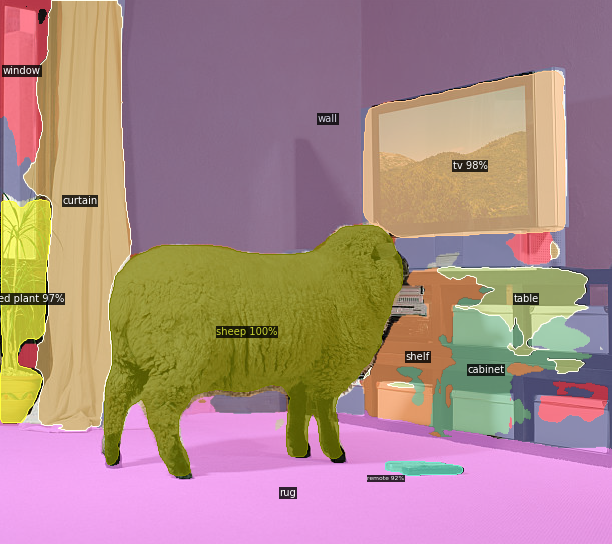

['sheep', 'tv', 'potted plant', 'remote', 'curtain', 'shelf', 'window', 'cabinet', 'table', 'wall', 'rug']
Out of context object: sheep


In [ ]:
img_path = "/content/OCD (65).jpg"
detector.onImage(img_path)